In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import concurrent
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from concurrent.futures import ThreadPoolExecutor
from IPython.core.display import display, HTML

warnings.filterwarnings("ignore")

In [2]:
# df = None

# def read_csv(url):
#     return pd.read_csv(url, dtype={
#         "CRS_DEP_TIME": str,
#         "DEP_TIME": str,
#         "CRS_ARR_TIME": str,
#         "MONTH": str,
#         "DAY_OF_MONTH": str,
#         "DAY_OF_WEEK": str,
#     })

# with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#     future_list = []

#     for index in range(1, 13):
#         future = executor.submit(read_csv, f"datasets/airline_arrival_delay/month{index}.csv")
#         future_list.append(future)

#     for future in future_list:
#         try:
#             result = future.result(timeout=20)
#             if df is None:
#                 df = result
#             else:
#                 df = df.append(result)
#         except Exception as e:
#             print("Cannot load", e)

In [3]:
# load dataset
use_columns = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "TailNum",
    "CRSElapsedTime",
    "ArrDelay",
    "Origin",
    "Dest",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "Cancelled",
    "Diverted",
]

df = pd.read_csv("datasets/airline_arrival_delay/2007_light.csv", dtype={
    "Month": str,
    "DayofMonth": str,
    "DayOfWeek": str,
    "DepTime": str,
    "CRSDepTime": str,
    "CRSArrTime": str,
    "FlightNum": str,
    "Diverted": str
}, usecols=use_columns)

def add_prefix(columns, prefix, additional_text=""):
    new_columns = []
    
    for col in columns:
        transform = ''.join([e.capitalize() for e in col.split('_')])
        
        if prefix.lower() == col.lower():
            new_columns.append(f"{prefix}{additional_text}")
        else:
            new_columns.append(f"{prefix}{additional_text}{transform}")
            
    return new_columns

df_carriers = pd.read_csv("datasets/airline_arrival_delay/carriers.csv")
df_carriers.columns = add_prefix(df_carriers.columns, "Carrier")

df_planes = pd.read_csv("datasets/airline_arrival_delay/plane-data.csv")
df_planes.columns = add_prefix(df_planes.columns, "Plane")

df_airports_from = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_from.columns = add_prefix(df_airports_from.columns, "Airport", "From")

df_airports_to = pd.read_csv("datasets/airline_arrival_delay/airports.csv")
df_airports_to.columns = add_prefix(df_airports_to.columns, "Airport", "To")

In [4]:
df = pd.merge(df, df_carriers, left_on="UniqueCarrier", right_on="CarrierCode", how="inner")
df = pd.merge(df, df_planes, left_on="TailNum", right_on="PlaneTailnum", how="inner")
df = pd.merge(df, df_airports_from, left_on="Origin", right_on="AirportFromIata", how="inner")
df = pd.merge(df, df_airports_to, left_on="Dest", right_on="AirportToIata", how="inner")

In [5]:
del df_carriers, df_planes, df_airports_from, df_airports_to

In [6]:
df = df.sample(n=3000000)

## All columns and their description

2. Month: ~~ 1-12
3. DayofMonth: ~~ 1-31
4. DayOfWeek: ~~ 1 (Monday) - 7 (Sunday)
5. CRSDepTime: ~~ scheduled departure time (local, hhmm)
6. CRSArrTime: ~~ scheduled arrival time (local, hhmm)
7. UniqueCarrier: ~~ unique carrier code
8. FlightNum: ~~ flight number
9. TailNum: ~~ plane tail number
10. CRSElapsedTime: ~~ in minutes ------ __have negative number__
11. ArrDelay: ~~ arrival delay, in minutes
12. Origin: ~~ origin IATA airport code
13. Dest: ~~ destination IATA airport code
14. Distance: ~~ in miles
15. TaxiIn: ~~ taxi in time, in minutes
16. TaxiOut: ~~ taxi out time in minutes
17. Cancelled: ~~ was the flight cancelled?
18. Diverted: ~~ 1 = yes, 0 = no

## Exploratory Data Analysis

In [7]:
# set labels for dataset
df["IsLate"] = df["ArrDelay"].apply(lambda x: x > 30)
# filter out cancelled flights
df = df[df["Cancelled"] == False]

# drop unnecessary columns
df = df.drop([
    "UniqueCarrier",
    "CarrierCode",
    "TailNum",
    "PlaneTailnum",
    "Origin",
    "AirportFromIata",
    "Dest",
    "AirportToIata",
    "ArrDelay",
    "Cancelled",
    "AirportFromCountry",
    "AirportToCountry",
], axis=1)

__CrsElapsedTime:__ Negative numbers means flying back in time zone (bay ngược múi giờ)

In [8]:
# after filtering unnecessary columns, we now have only 21 features and 1 label
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2981676 entries, 5362937 to 5787361
Data columns (total 31 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Month               object 
 1   DayofMonth          object 
 2   DayOfWeek           object 
 3   CRSDepTime          object 
 4   CRSArrTime          object 
 5   FlightNum           object 
 6   CRSElapsedTime      float64
 7   Distance            int64  
 8   TaxiIn              int64  
 9   TaxiOut             int64  
 10  Diverted            object 
 11  CarrierDescription  object 
 12  PlaneType           object 
 13  PlaneManufacturer   object 
 14  PlaneIssueDate      object 
 15  PlaneModel          object 
 16  PlaneStatus         object 
 17  PlaneAircraftType   object 
 18  PlaneEngineType     object 
 19  PlaneYear           object 
 20  AirportFrom         object 
 21  AirportFromCity     object 
 22  AirportFromState    object 
 23  AirportFromLat      float64
 24  AirportFromLong   

In [9]:
df.describe()

,CRSElapsedTime,Distance,TaxiIn,TaxiOut,AirportFromLat,AirportFromLong,AirportToLat,AirportToLong
count,2.981676e+06,2.981676e+06,2.981676e+06,2.981676e+06,2.981676e+06,2.981676e+06,2.981676e+06,2.981676e+06
mean,1.289926e+02,7.356967e+02,6.811820e+00,1.665930e+01,3.673747e+01,-9.554651e+01,3.673897e+01,-9.554607e+01
std,7.156558e+01,5.719390e+02,5.117393e+00,1.177106e+01,5.756340e+00,1.838034e+01,5.755896e+00,1.838112e+01
min,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.770189e+01,-1.766460e+02,1.770189e+01,-1.766460e+02
25%,7.800000e+01,3.250000e+02,4.000000e+00,1.000000e+01,3.343417e+01,-1.119778e+02,3.343417e+01,-1.119778e+02
50%,1.100000e+02,5.870000e+02,6.000000e+00,1.400000e+01,3.750517e+01,-8.997667e+01,3.750517e+01,-8.997667e+01
75%,1.600000e+02,9.640000e+02,8.000000e+00,1.900000e+01,4.077724e+01,-8.131603e+01,4.077724e+01,-8.131603e+01
max,6.600000e+02,4.962000e+03,5.450000e+02,5.300000e+02,7.128545e+01,-6.479856e+01,7.128545e+01,-6.479856e+01


In [10]:
df.describe(include="O").T

,count,unique,top,freq
Month,2981676,12,8,266271
DayofMonth,2981676,31,12,100147
DayOfWeek,2981676,7,1,444654
CRSDepTime,2981676,1178,600,52614
CRSArrTime,2981676,1382,1930,10907
FlightNum,2981676,7562,1,2281
Diverted,2981676,2,0,2974857
CarrierDescription,2981676,19,Southwest Airlines Co.,468184
PlaneType,2827726,5,Corporation,2808559
PlaneManufacturer,2827726,35,BOEING,1168121


In [11]:
df.head(5).T

,5362937,1917153,1109333,2410438,6438736
Month,7,3,7,11,11
DayofMonth,12,11,17,9,28
DayOfWeek,4,7,2,5,3
CRSDepTime,1030,1328,1808,740,745
CRSArrTime,1540,1455,1841,1455,849
FlightNum,1719,6530,5664,1186,2872
CRSElapsedTime,190,87,33,255,64
Distance,1312,458,77,1946,217
TaxiIn,5,4,6,6,4
TaxiOut,9,9,7,14,14


In [12]:
print(f"Total rows: {len(df)}")

Total rows: 2981676


### Check missing values

In [13]:
# list all columns with their total missing values
nan_summary = df.isnull().sum()
nan_summary

Month                      0
DayofMonth                 0
DayOfWeek                  0
CRSDepTime                 0
CRSArrTime                 0
FlightNum                  0
CRSElapsedTime             0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Diverted                   0
CarrierDescription         0
PlaneType             153950
PlaneManufacturer     153950
PlaneIssueDate        153950
PlaneModel            153950
PlaneStatus           153950
PlaneAircraftType     153950
PlaneEngineType       153950
PlaneYear             153950
AirportFrom                0
AirportFromCity         2160
AirportFromState        2160
AirportFromLat             0
AirportFromLong            0
AirportTo                  0
AirportToCity           2079
AirportToState          2079
AirportToLat               0
AirportToLong              0
IsLate                     0
dtype: int64

In [14]:
# the missing value only 5% which is not really significant => drop all missing value
df = df.dropna()

### Heatmap visualization

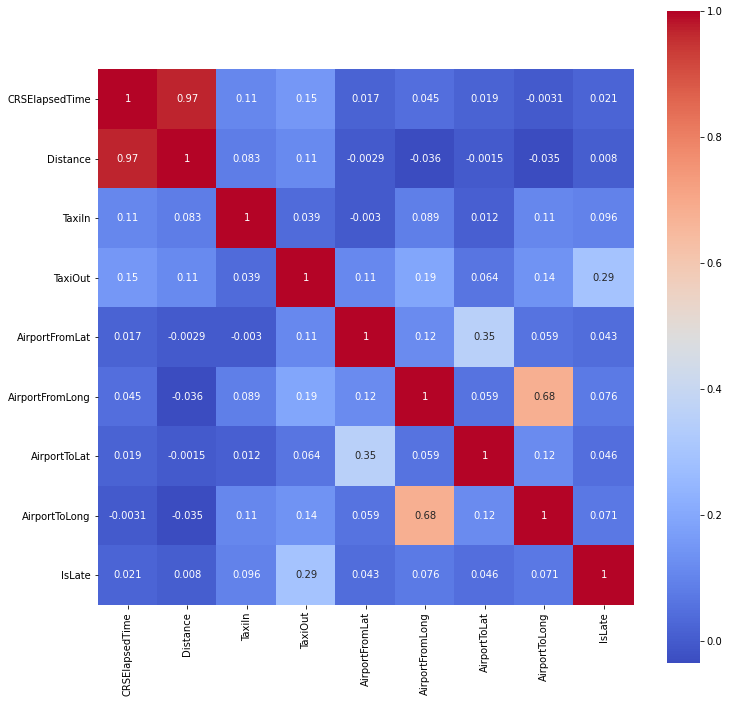

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True, cmap="coolwarm", ax=ax);

# the scheduled time & actual time is strictly correlated -> should get the difference
# airtime & distance are also correlated with actual & schedule elapsed time

### Visualization numerical data based on IsLate label

<Figure size 720x504 with 0 Axes>

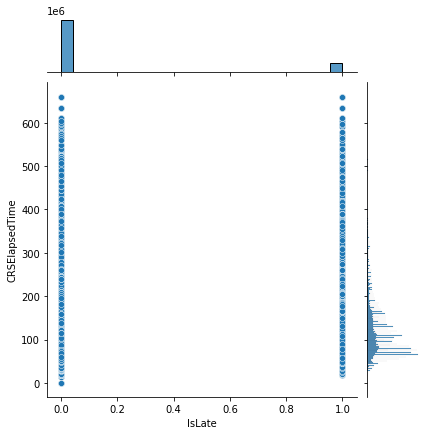

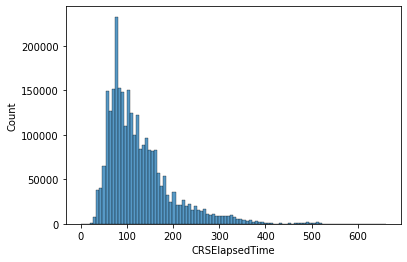

<Figure size 720x504 with 0 Axes>

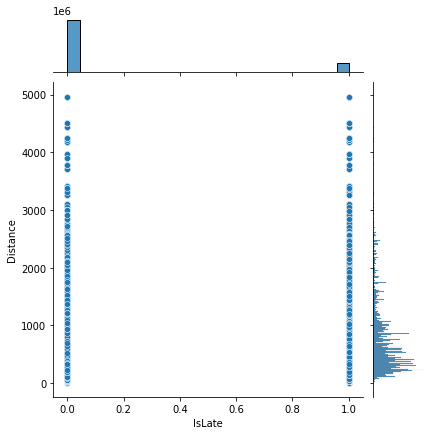

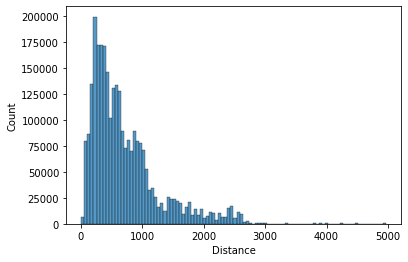

<Figure size 720x504 with 0 Axes>

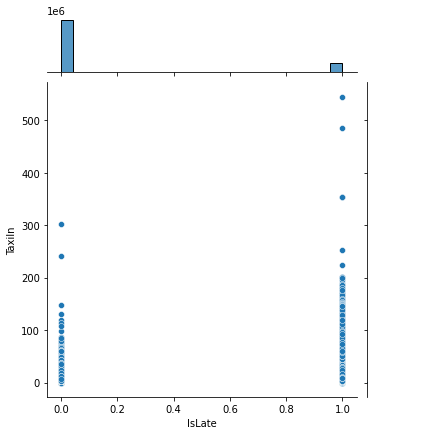

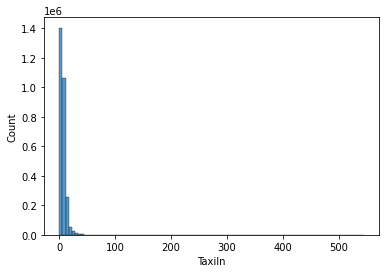

<Figure size 720x504 with 0 Axes>

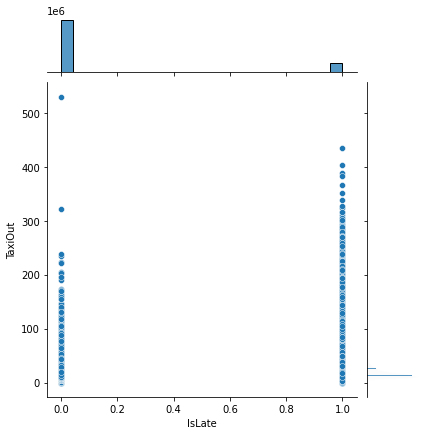

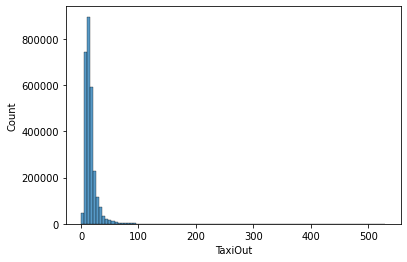

<Figure size 720x504 with 0 Axes>

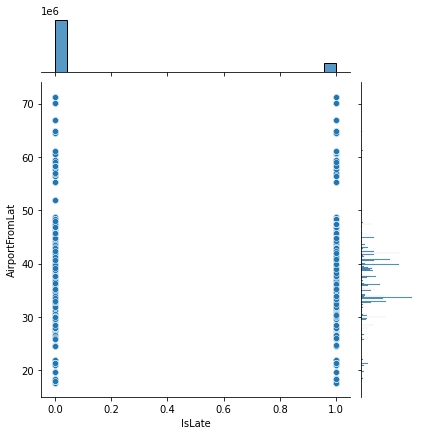

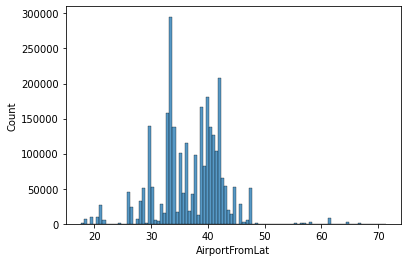

<Figure size 720x504 with 0 Axes>

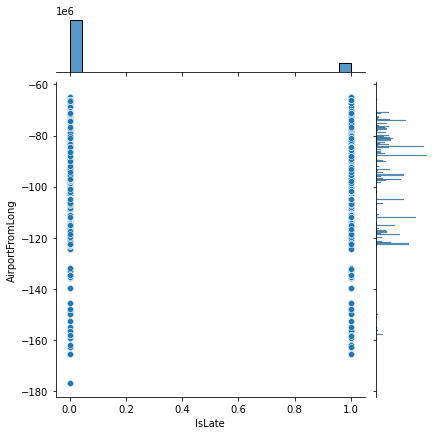

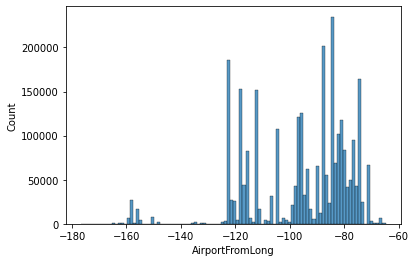

<Figure size 720x504 with 0 Axes>

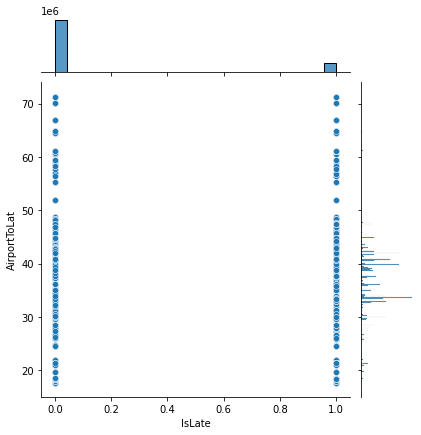

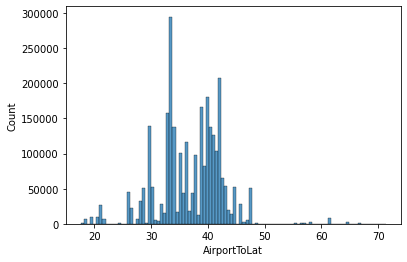

<Figure size 720x504 with 0 Axes>

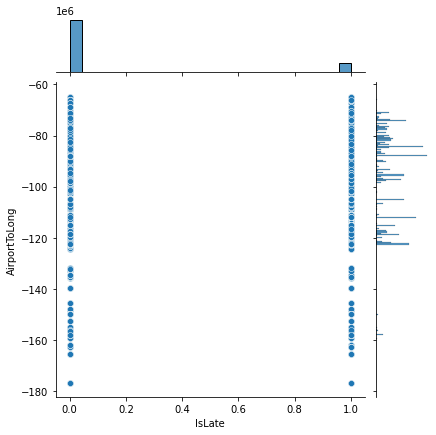

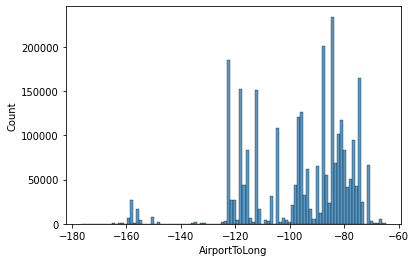

In [16]:
numerical_features = [
    "CRSElapsedTime",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "AirportFromLat",
    "AirportFromLong",
    "AirportToLat",
    "AirportToLong"
]

for column in numerical_features:
    plt.figure(figsize=(10, 7))
    display(HTML(f"<h4>{column}</h4>"))
    
    sns.jointplot(data=df, x="IsLate", y=column);
    plt.show()
    
    sns.histplot(df[column], bins=100);
    plt.show()

# Via data population, I can see that only the features like TaxiIn, Taxiout affect the lateness directly
# Significantly, distance doesn't show any relation with IsLate

### Visualization categorical data based on IsLate label

In [17]:
def split_hour(date):
    return date[:2]

def add_prefix_to_date(day):
    if len(day) == 1:
        return f"0{day}"
    
    return day

def add_prefix_to_time(time):
    return time.rjust(4, "0")

# df = df_backup.copy()
df["CRSDepTime"] = df["CRSDepTime"].apply(add_prefix_to_time)
df["CRSArrTime"] = df["CRSArrTime"].apply(add_prefix_to_time)
df["CRSDepTime_Hour"] = df["CRSDepTime"].apply(split_hour)
df["CRSArrTime_Hour"] = df["CRSArrTime"].apply(split_hour)
df["Month"] = df["Month"].apply(add_prefix_to_date)
df["DayofMonth"] = df["DayofMonth"].apply(add_prefix_to_date)
df["Diverted"] = df["Diverted"].map({"0": "Non-diverted", "1": "Diverted"})
df["PlaneIssueYear"] = df["PlaneIssueDate"].apply(lambda e: e.split("/")[-1])

# diverted is all NaN column, so I would drop this feature
df = df.drop(["CRSDepTime", "CRSArrTime", "PlaneIssueDate", "Diverted"], axis=1)

In [18]:
def calculate_categorical_percentage(df, column):
    visualize = df.groupby(column)["IsLate"].value_counts().sort_index().to_frame()
    visualize["TotalFlights"] = df.groupby(column)["IsLate"].value_counts().values
    visualize = visualize.drop(["IsLate"], axis=1).sort_index().reset_index()
    
    column_values1 = visualize[visualize["IsLate"] == True][column].unique()
    column_values2 = visualize[visualize["IsLate"] == False][column].unique()
    
    column_values = list(set(column_values1) & set(column_values2))
    column_values.sort()
    
    total_flights = visualize[visualize[column].isin(column_values)].groupby(column)["TotalFlights"].sum()
    is_late = visualize[(visualize["IsLate"] == True) & (visualize[column].isin(column_values))]["TotalFlights"]
    is_not_late = visualize[(visualize["IsLate"] == False) & (visualize[column].isin(column_values))]["TotalFlights"]

    is_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_late)]
    is_not_late_percentage = [value / total_flights[i] * 100 for i, value in enumerate(is_not_late)]
    
    return visualize, column_values, is_late_percentage, is_not_late_percentage

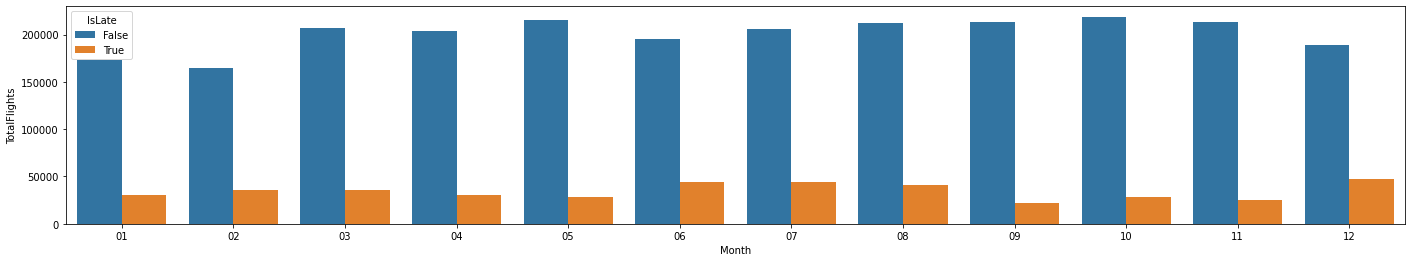

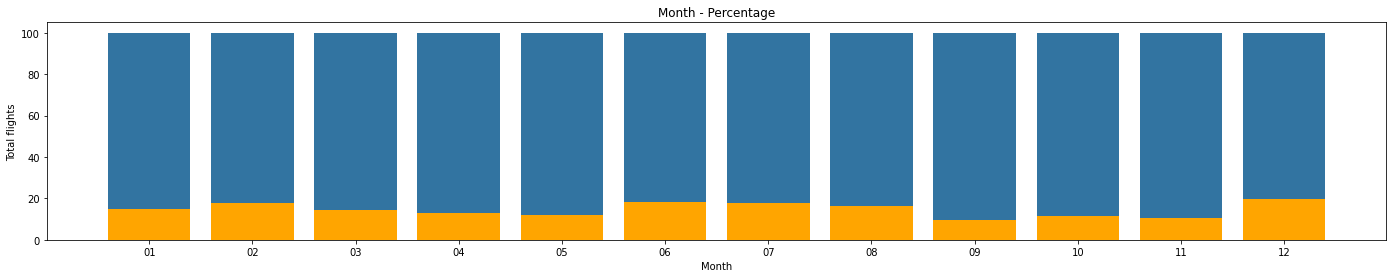

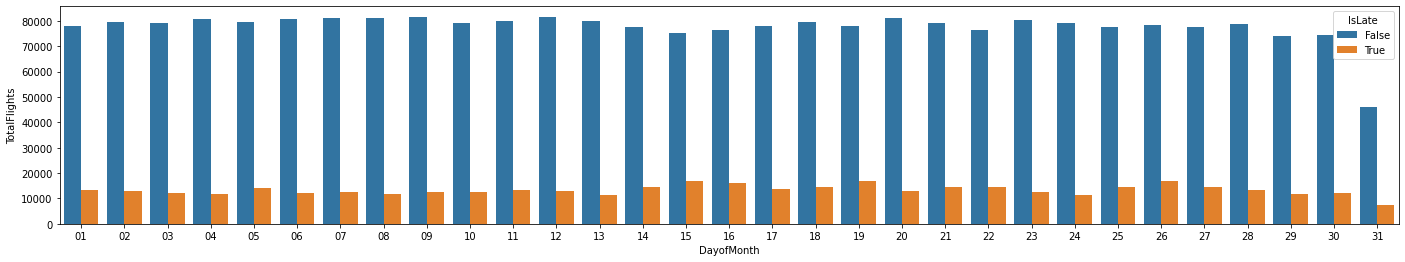

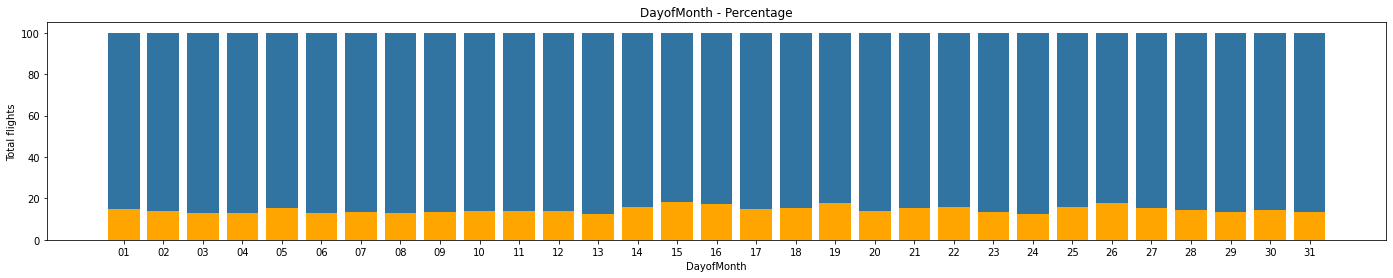

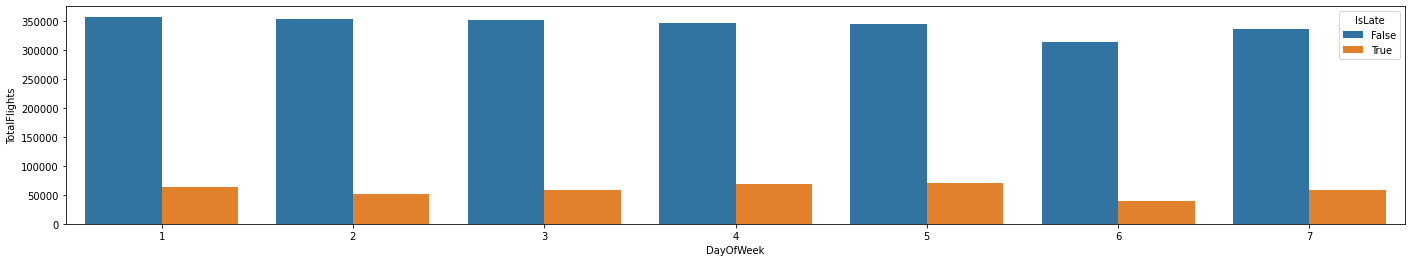

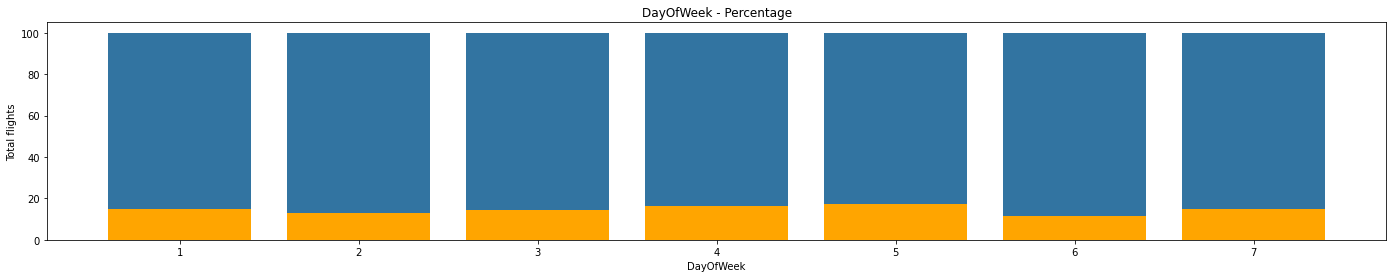

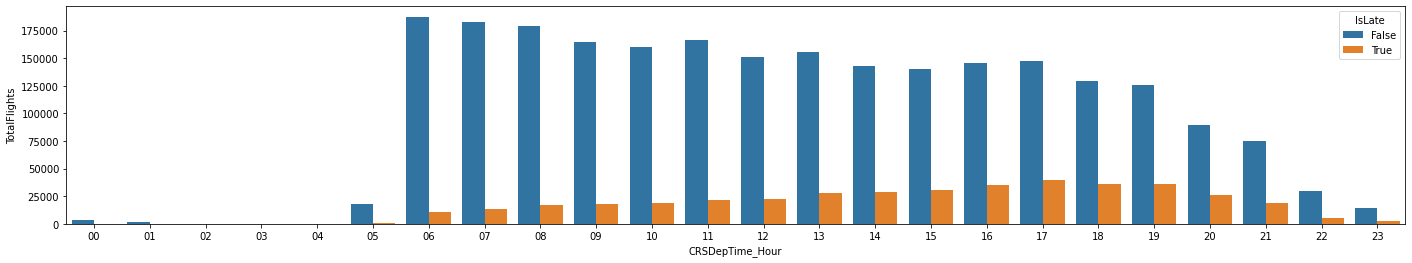

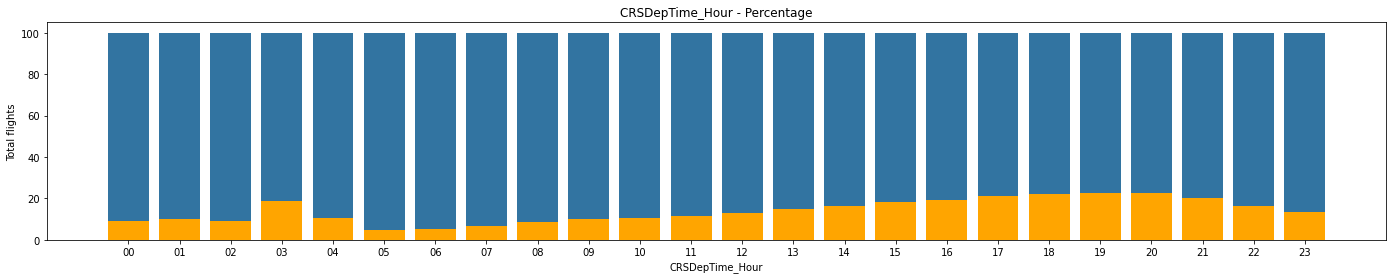

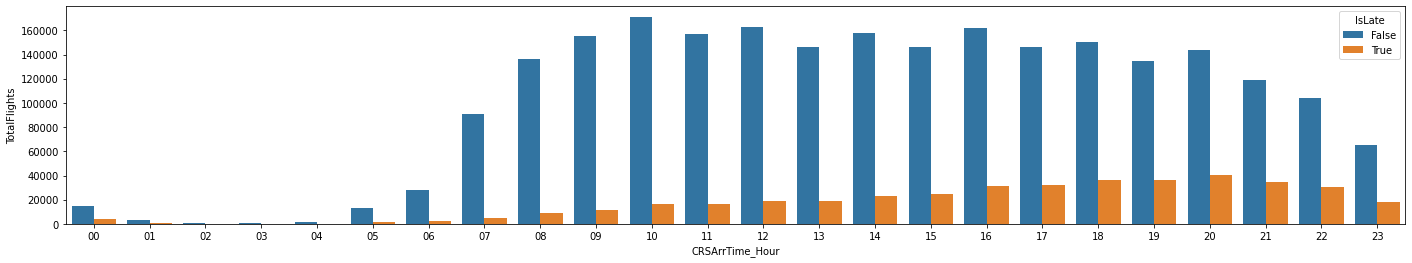

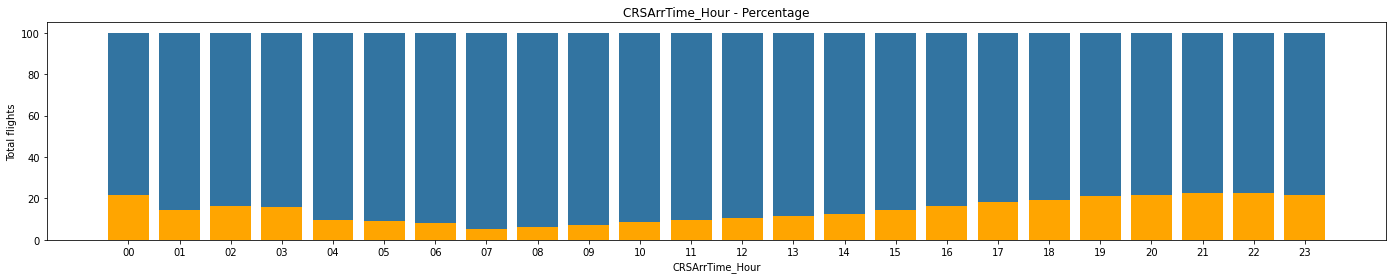

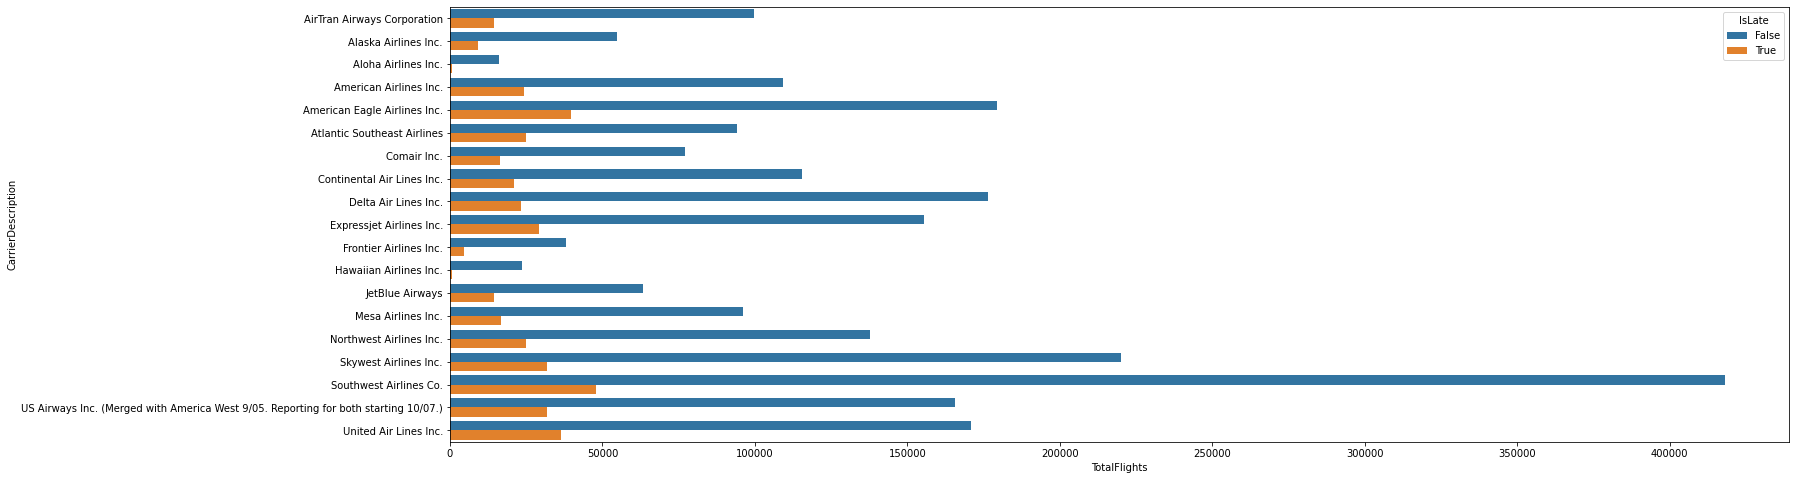

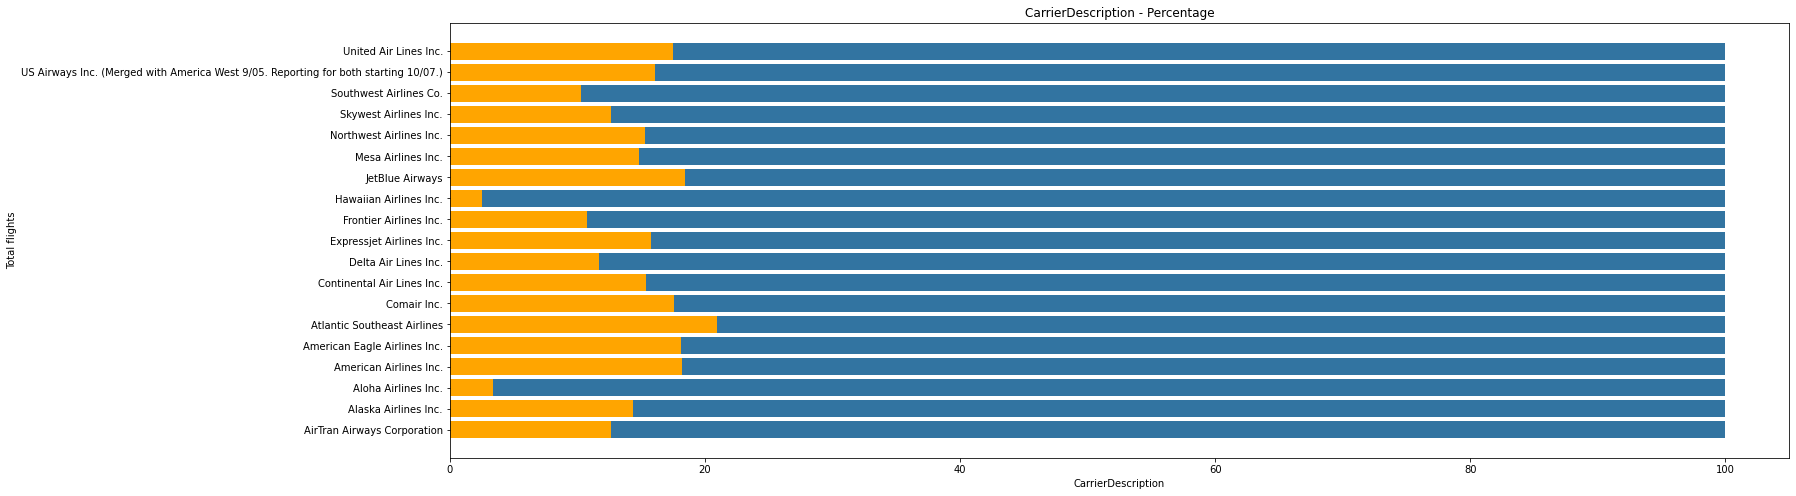

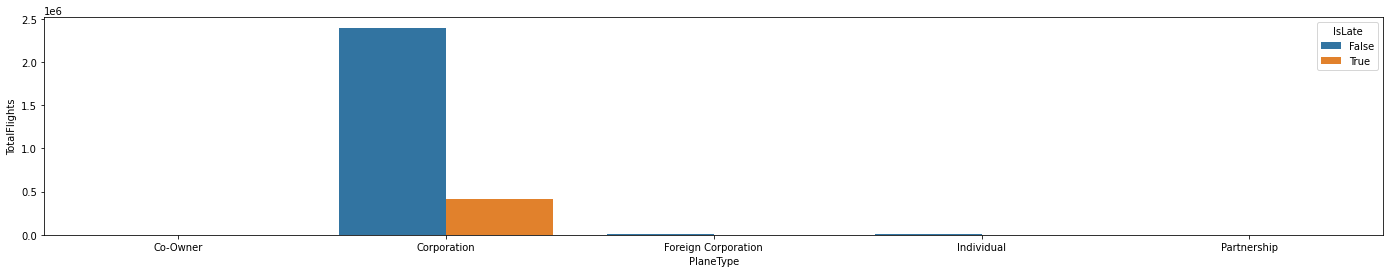

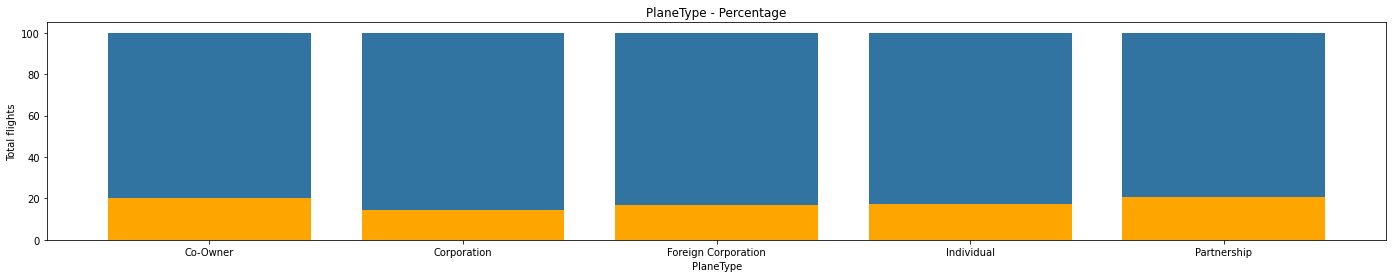

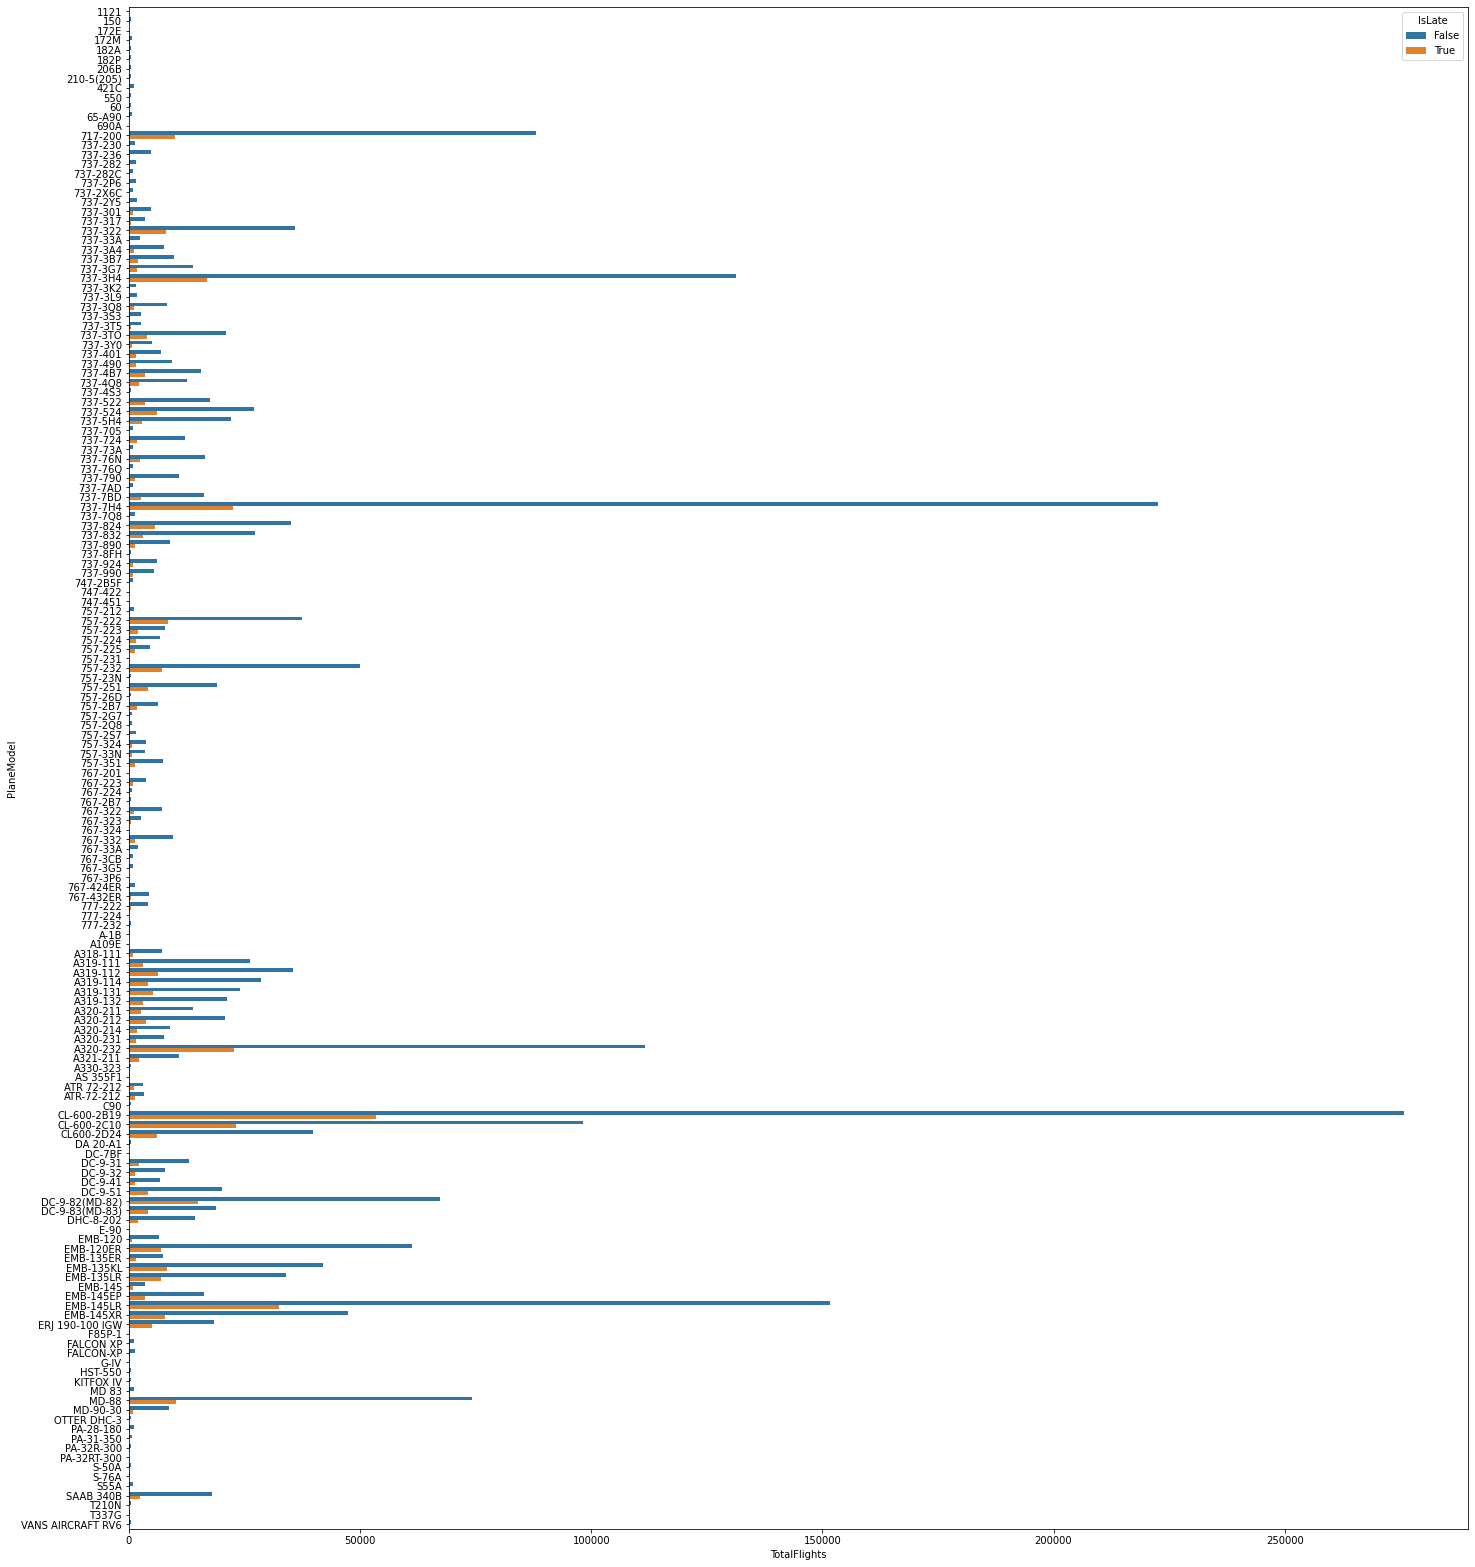

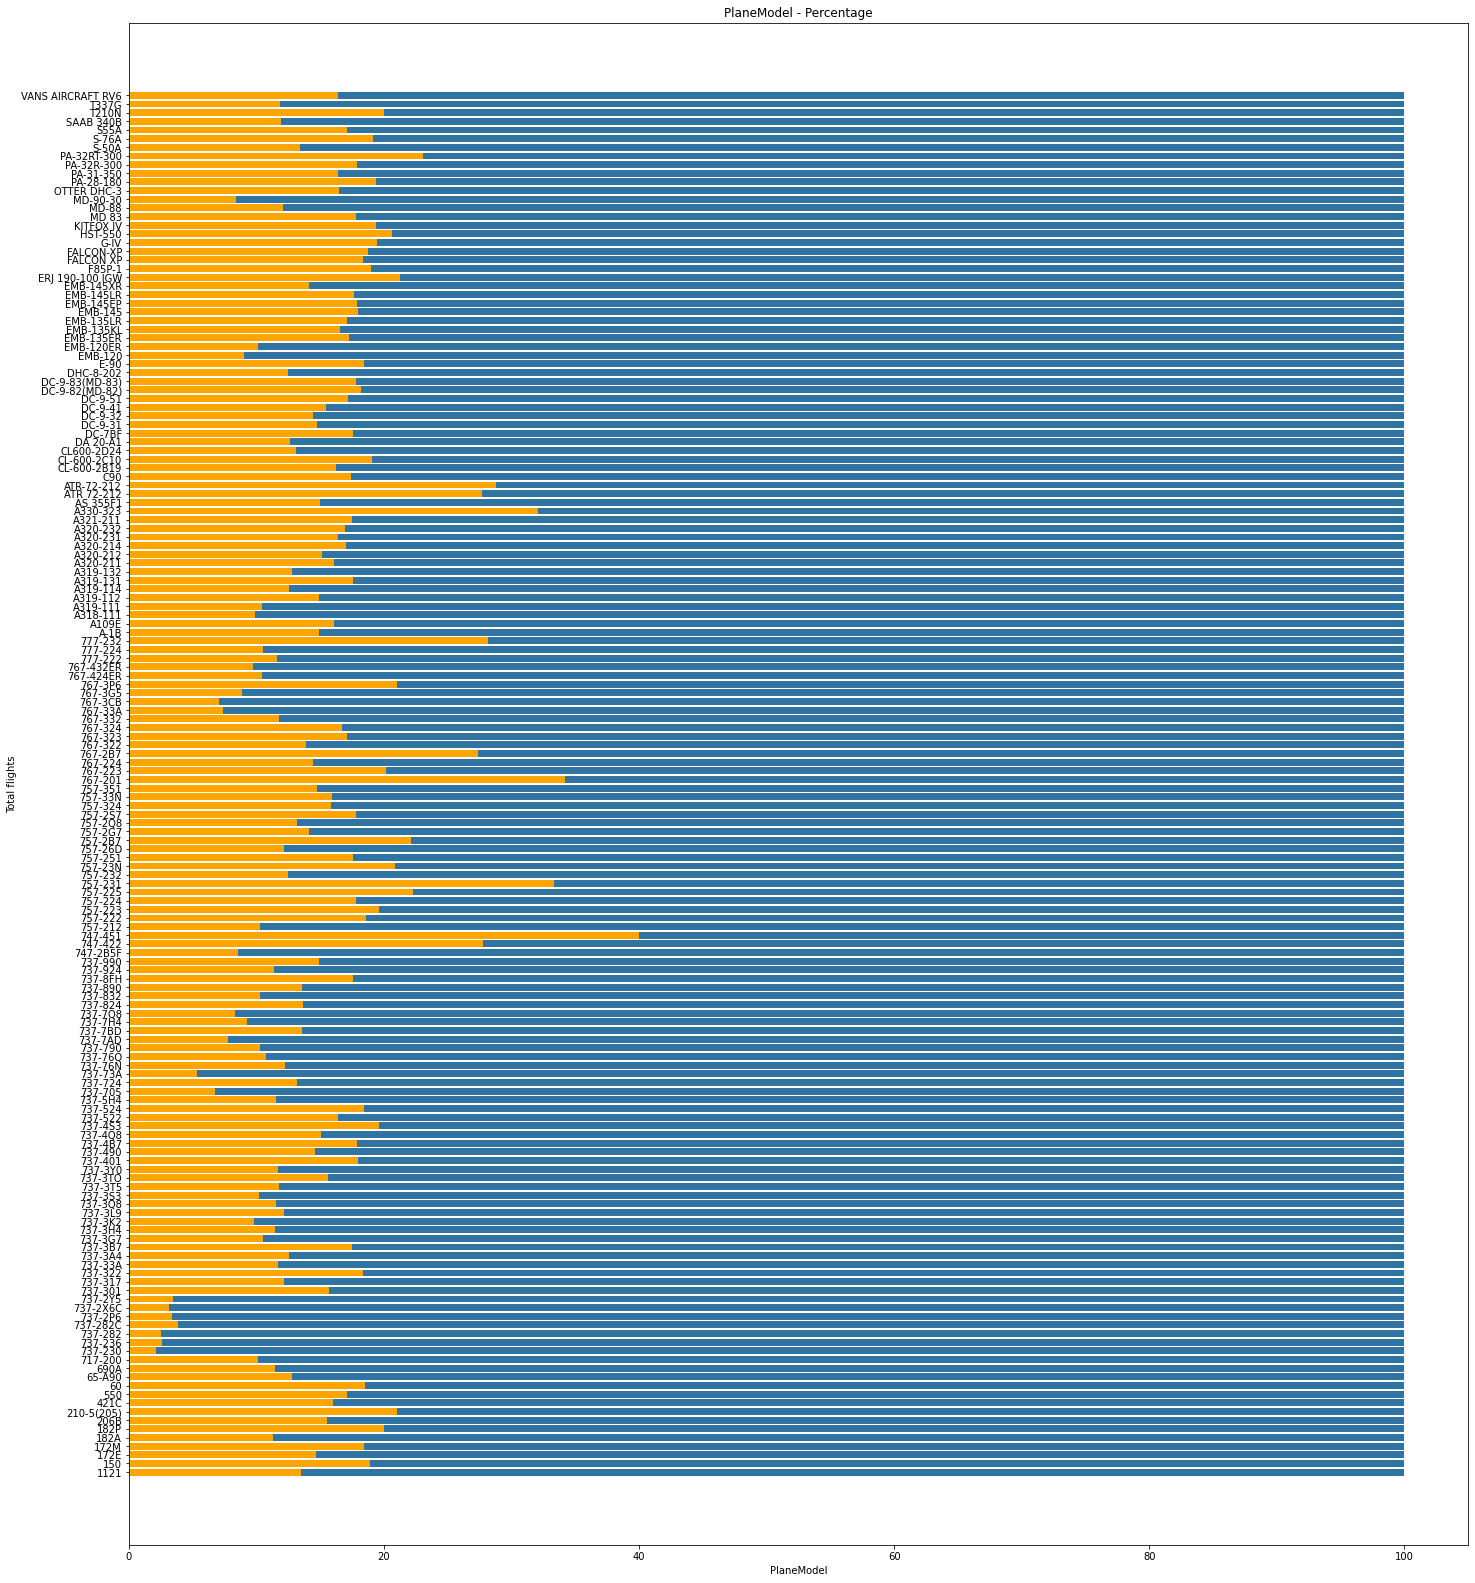

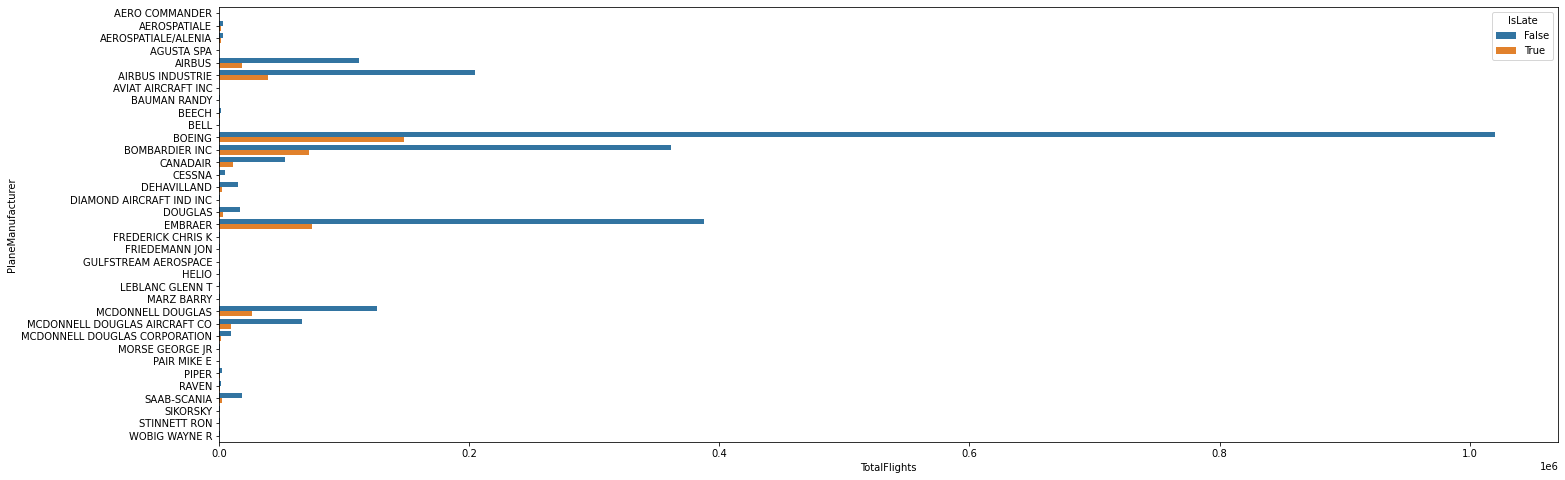

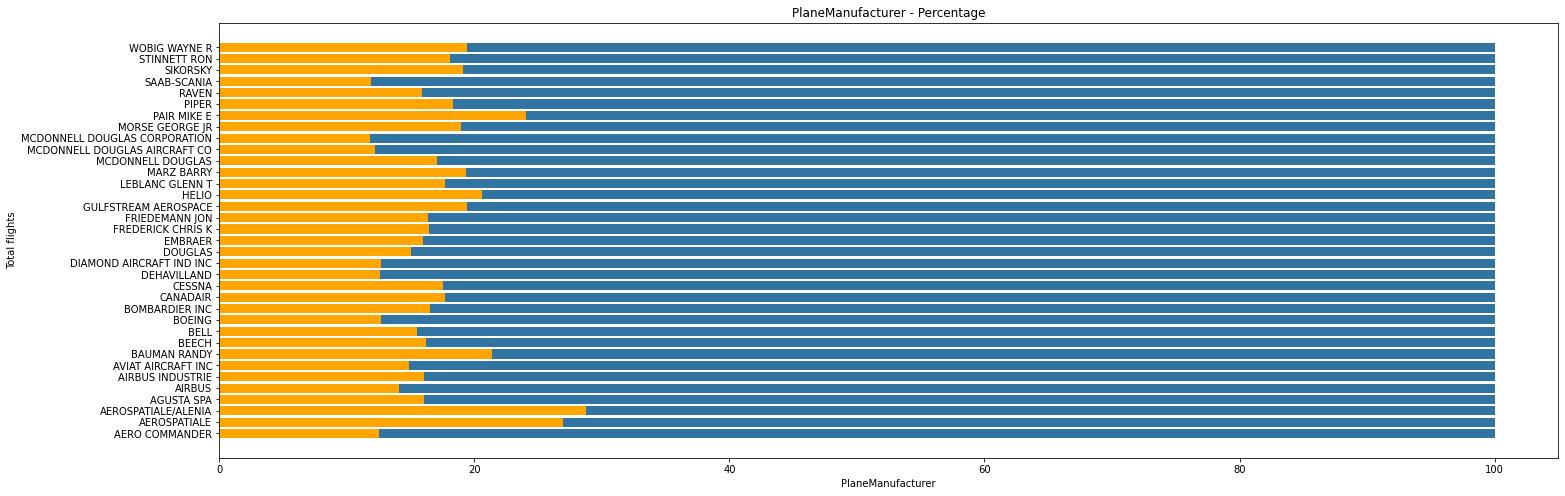

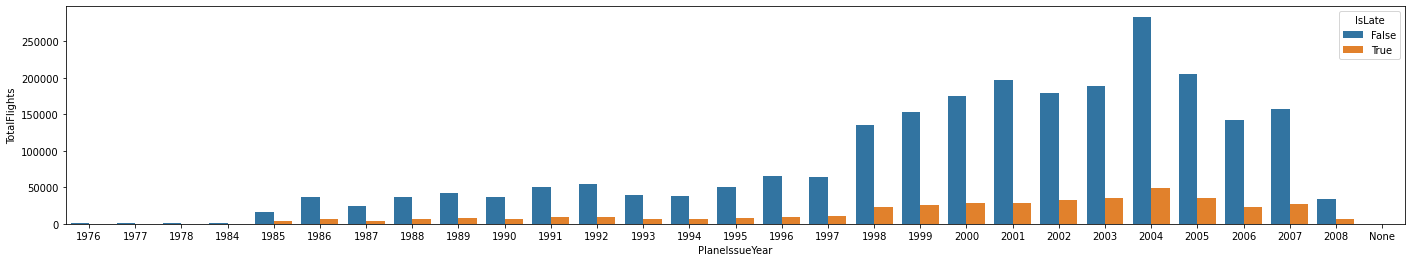

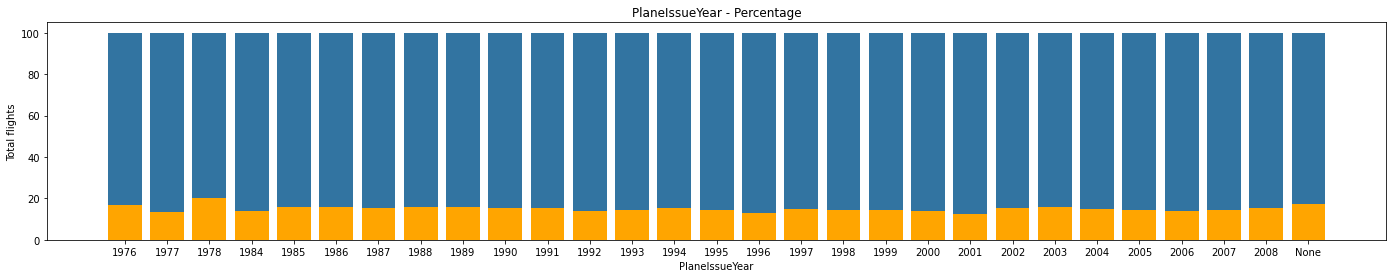

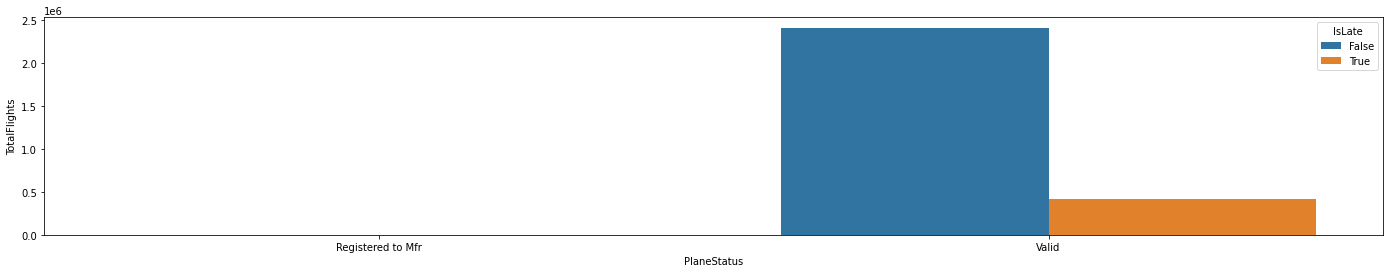

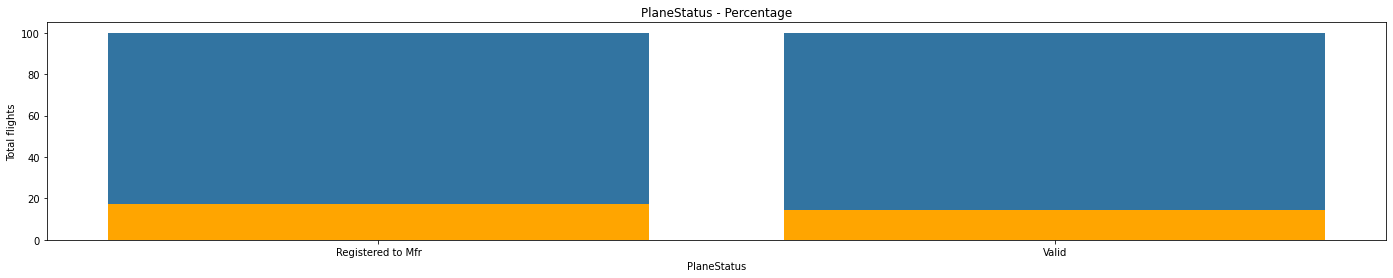

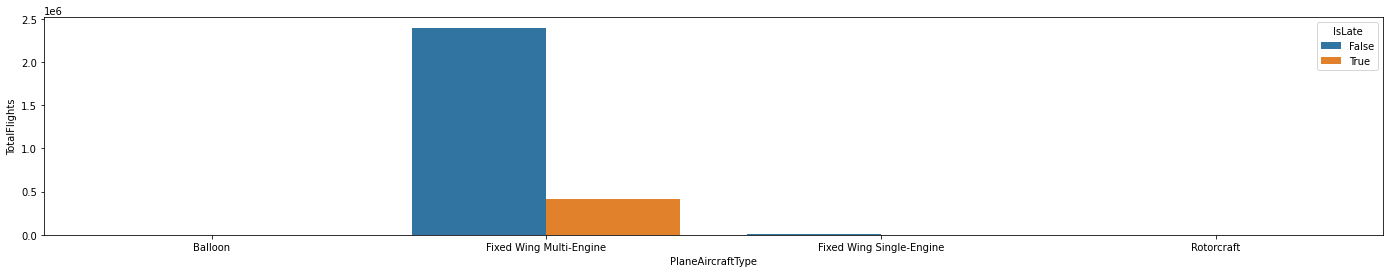

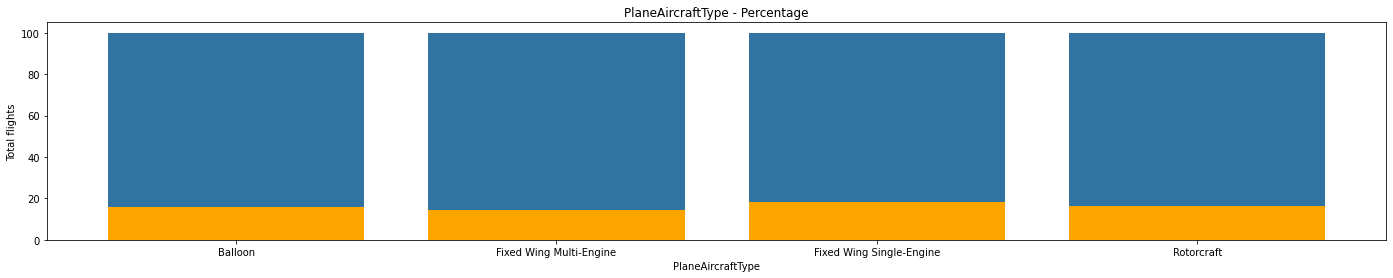

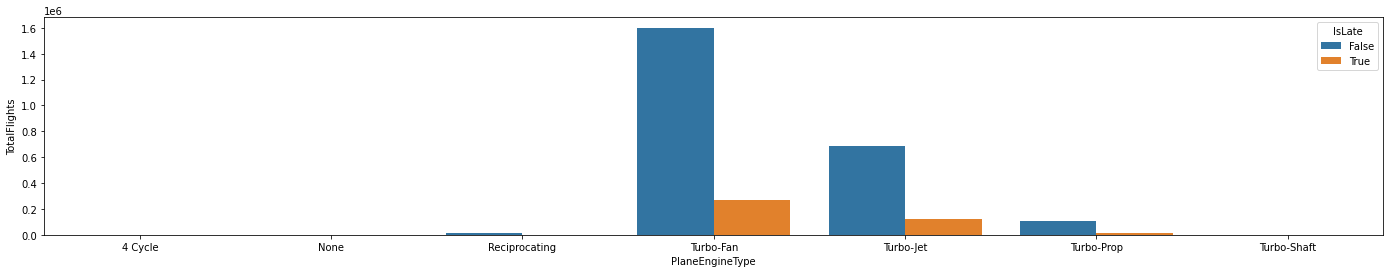

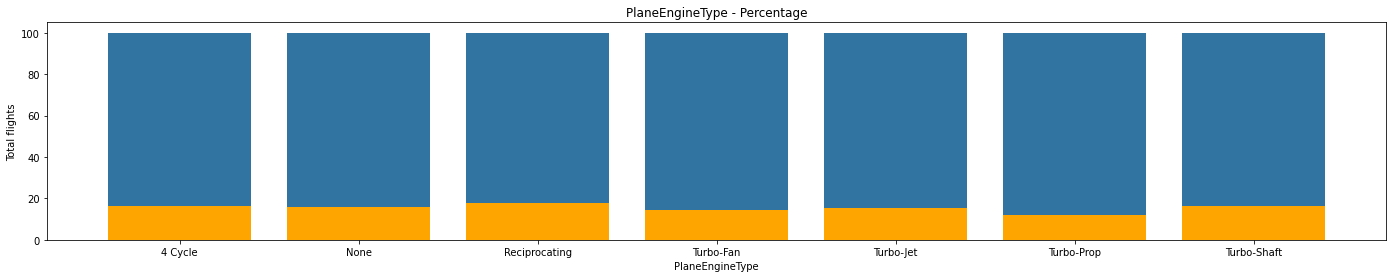

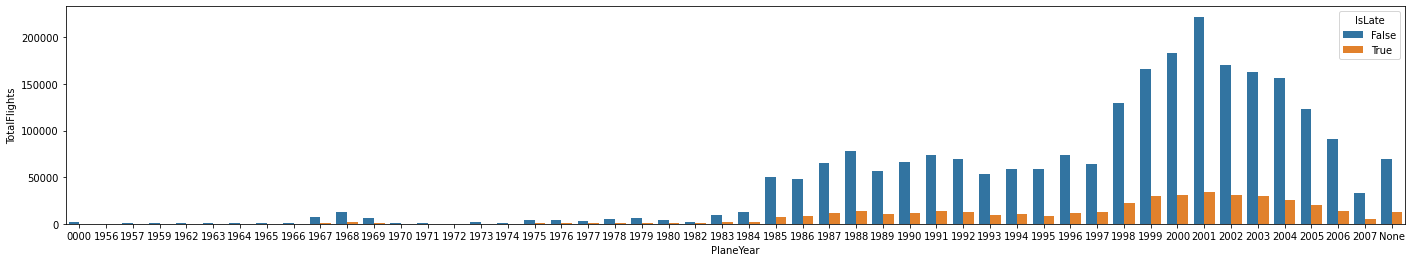

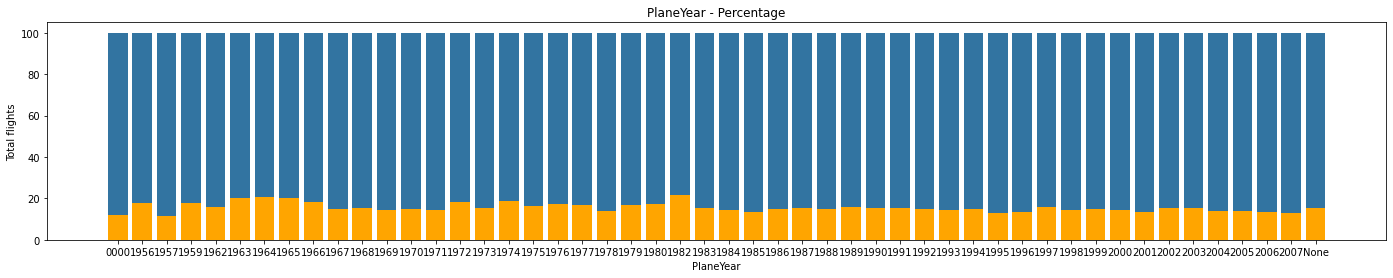

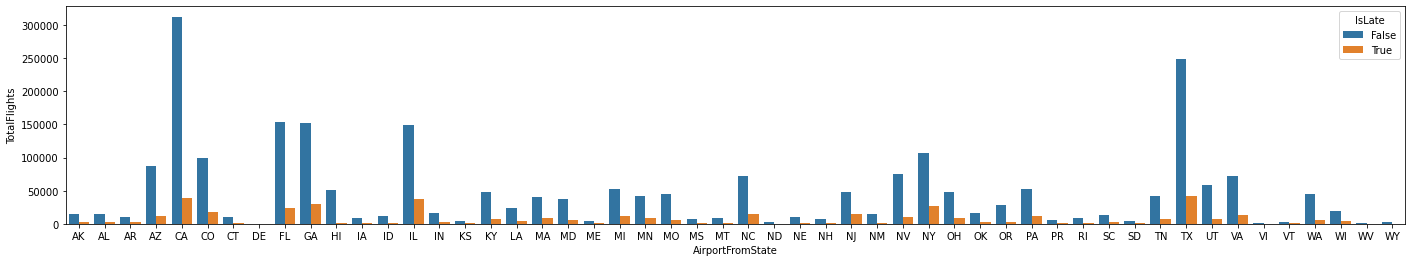

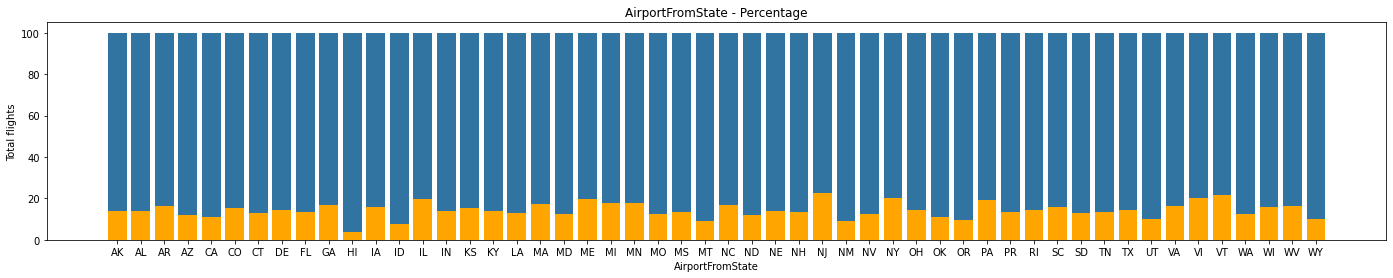

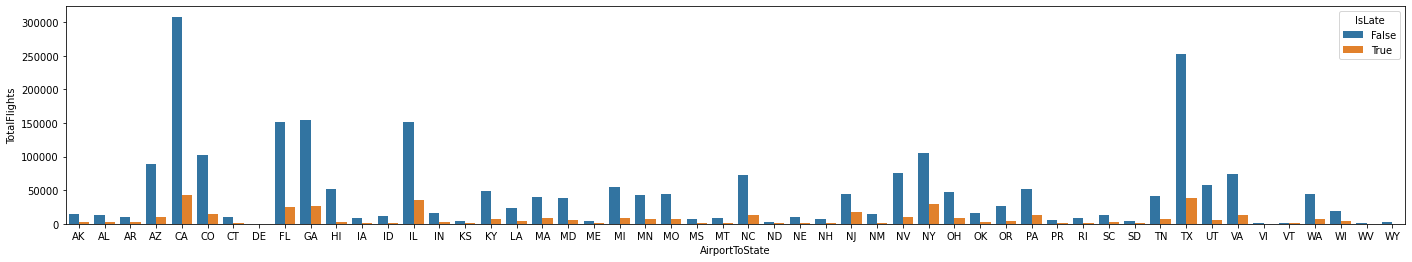

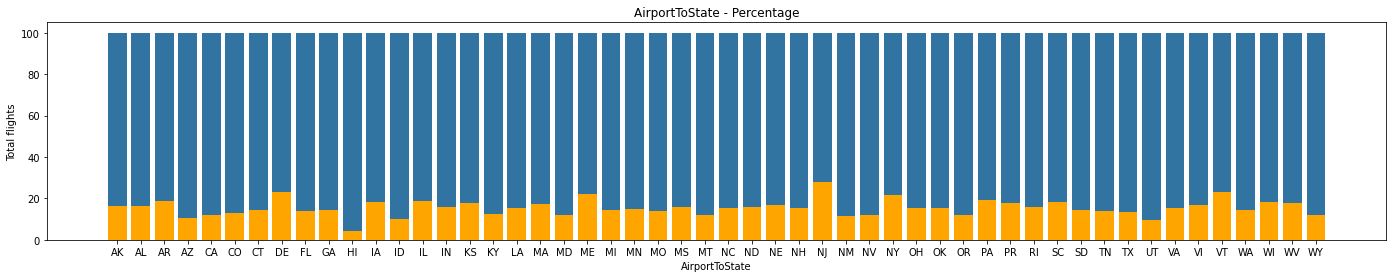

In [19]:
categorical_features = [
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime_Hour",
    "CRSArrTime_Hour",
    "CarrierDescription",
    "PlaneType",
    "PlaneModel",
    "PlaneManufacturer",
    "PlaneIssueYear",
    "PlaneStatus",
    "PlaneAircraftType",
    "PlaneEngineType",
    "PlaneYear",
    "AirportFromState",
    "AirportToState",
]
barh_columns = [
    "PlaneModel",
    "PlaneManufacturer",
    "CarrierDescription"
]

for column in categorical_features:
    visualize, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column)
    
    display(HTML(f"<h4>{column}</h4>"))

    # show IsLate percentage
    
    
    if column in barh_columns:
        height = 8 if column != "PlaneModel" else 28
        
        plt.figure(figsize=(24, height))
        sns.barplot(x="TotalFlights", hue="IsLate", y=column, data=visualize);
        plt.show()
        
        plt.figure(figsize=(24, height))
        plt.barh(column_values, is_late_percentage, color="orange")
        plt.barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    else:
        plt.figure(figsize=(24, 4))
        sns.barplot(x=column, hue="IsLate", y="TotalFlights", data=visualize);
        plt.show()
    
        plt.figure(figsize=(24, 4))
        plt.bar(column_values, is_late_percentage, color="orange")
        plt.bar(column_values, is_not_late_percentage, bottom=is_late_percentage, color="#3274a1")
        
    plt.xlabel(column)
    plt.ylabel("Total flights")
    plt.title(f"{column} - Percentage")
    plt.show()

From the visualized data, we can see that PlaneModel, DayofMonth, CRSDepTime_Hour, CRSArrTime_Hour, Month (4 months), CarrierDescription, PlaneManufacturer, AirportFromState, AirportToState have significant impact to the lateness of Flights.

In contrast, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, AircraftType don't show any promising influence to the lateness

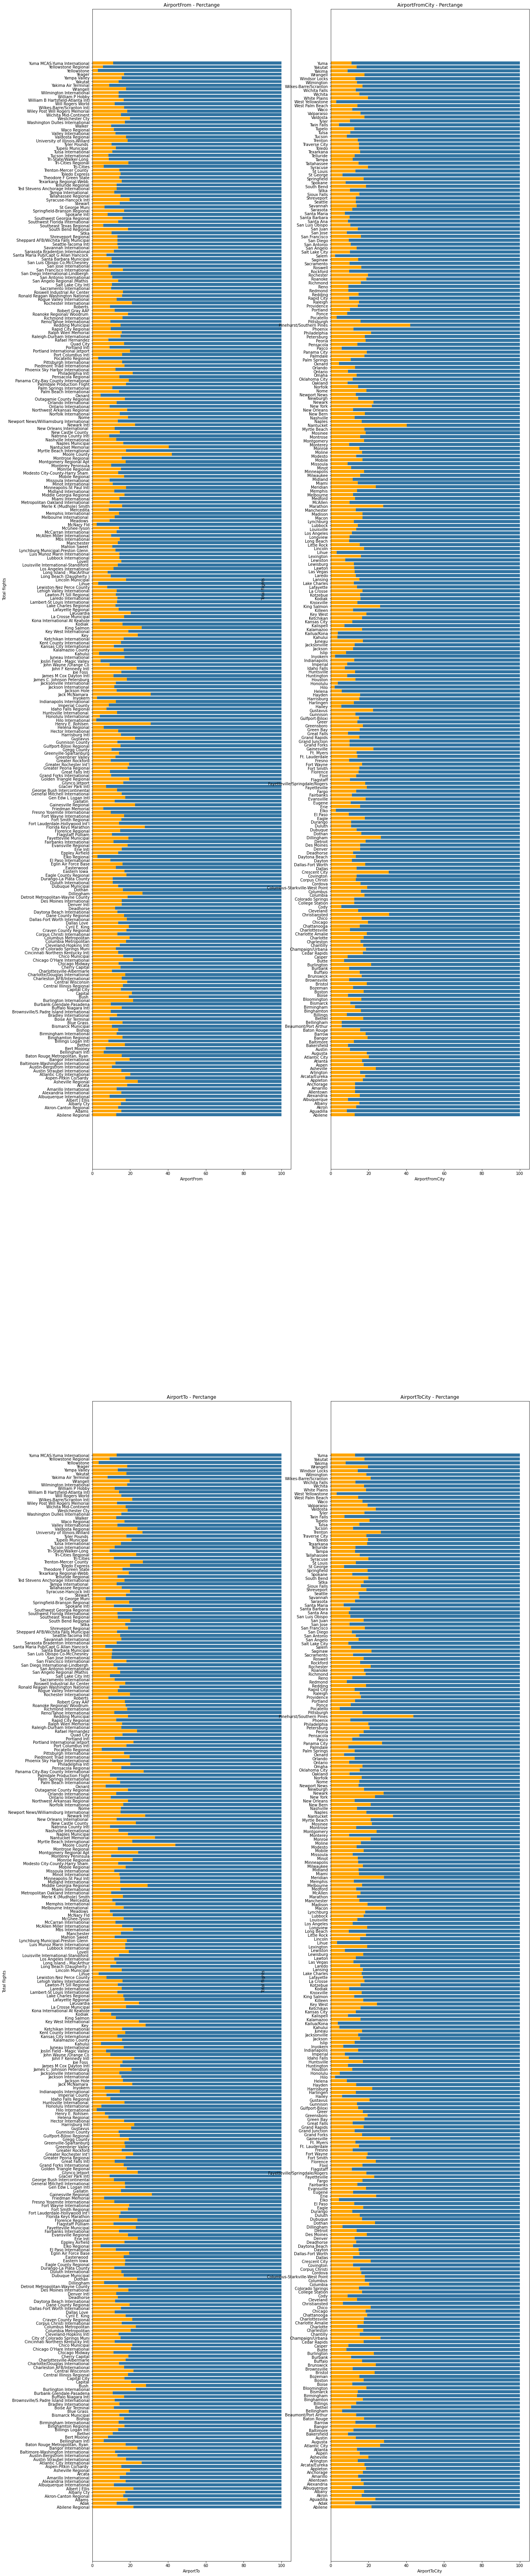

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(20, 120))
columns = [["AirportFrom", "AirportFromCity"], ["AirportTo", "AirportToCity"]]

for index, (column1, column2) in enumerate(columns):
    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column1)

    ax[index][0].barh(column_values, is_late_percentage, color="orange")
    ax[index][0].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][0].set_xlabel(column1)
    ax[index][0].set_ylabel("Total flights")
    ax[index][0].set_title(f"{column1} - Perctange")

    _, column_values, is_late_percentage, is_not_late_percentage = calculate_categorical_percentage(df, column2)
    ax[index][1].barh(column_values, is_late_percentage, color="orange")
    ax[index][1].barh(column_values, is_not_late_percentage, left=is_late_percentage, color="#3274a1")
    ax[index][1].set_xlabel(column2)
    ax[index][1].set_ylabel("Total flights")
    ax[index][1].set_title(f"{column2} - Perctange")

plt.show()

<!--  "Origin", "Dest",  -->
According to the data, the late percentage is higher in the summer and winter season (by month) and in the night time. The DayOfWeek doesn't seem to have any impact on the lateness. Furthermore, DayOfMonth also doesn't show a clear effect on the lateness.

The most significant feature here is OpUniqueCarier, the late flights varies depending on this feature, because obviously there are some carriers most of the times depart in incorrected timing.

Besides, origin and dest also contribute to the lateness. Because there are bad and good conditioning airports, large and small area, easily for flights to depart and land, ...

### Hypothesis Testing

In [21]:
# show 31 days in every month to check when the demands increase
# show the lateness also

### Filter noise & Feature engineering

In [22]:
from scipy import stats

# due to having too manu unique values, we drop AirportFrom, AirportFromCity, AirportTo, AirportToCity, and FlightNum
# similarly, DayOfWeek, PlaneType, PlaneIssueYear, PlaneStatus, PlaneEngineType, and PlaneAircraftType don't show any relation to the lateness
df = df.drop([
    "DayofMonth",
    "DayOfWeek",
    "PlaneType",
    "PlaneStatus",
    "FlightNum",
    "PlaneAircraftType",
    "PlaneEngineType",
    "AirportFrom",
    "AirportFromCity",
    "AirportTo",
    "AirportToCity",
    # test random forest
    "PlaneModel",
    # PlaneYear and PlaneIssueYear also have plenty values whcih doesn't show a significant difference
    "PlaneYear",
    "PlaneIssueYear",
], axis=1)

# Q1,Q3 = np.percentile(sorted(df['Price']),[25,75])
# IQR = Q3 - Q1
# upperlim = Q3 + 1.5*IQR
# lowerlim = max(Q1 - 1.5*IQR,0)

# calculate z-score to filter noise
for feature in numerical_features:
    z_scores = np.abs(stats.zscore(df[feature]))
    df = df[z_scores <= 3]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552591 entries, 5362937 to 5787361
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Month               object 
 1   CRSElapsedTime      float64
 2   Distance            int64  
 3   TaxiIn              int64  
 4   TaxiOut             int64  
 5   CarrierDescription  object 
 6   PlaneManufacturer   object 
 7   AirportFromState    object 
 8   AirportFromLat      float64
 9   AirportFromLong     float64
 10  AirportToState      object 
 11  AirportToLat        float64
 12  AirportToLong       float64
 13  IsLate              bool   
 14  CRSDepTime_Hour     object 
 15  CRSArrTime_Hour     object 
dtypes: bool(1), float64(5), int64(3), object(7)
memory usage: 314.0+ MB


In [24]:
dummy_columns = ["CarrierDescription", "PlaneManufacturer", "AirportFromState", "AirportToState"]

for column in dummy_columns:
    df = df.join(pd.get_dummies(df[column], column, drop_first=True, dtype=bool))
    
df = df.drop(dummy_columns, axis=1)

In [25]:
# feature engineering
# I see the abnormal from these hours and months, so I decided to create the new features for them
# calculate IG of CRSElapsedTime and Distance
df["IsArrTimeNoonOrEvening"] = df["CRSArrTime_Hour"].isin([str(i) for i in range(13, 24)])
df["IsUnusualCRSDepHour"] = df["CRSDepTime_Hour"].isin(["16", "17", "18", "19", "20", "21", "22", "23", "00", "01", "02", "03"])
df["IsSummerOrWinter"] = df["Month"].isin(["12", "01", "02", "06", "07", "08"])

df = df.drop(["CRSArrTime_Hour", "CRSDepTime_Hour", "Month"], axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552591 entries, 5362937 to 5787361
Columns: 157 entries, CRSElapsedTime to IsSummerOrWinter
dtypes: bool(149), float64(5), int64(3)
memory usage: 618.0 MB


In [27]:
from sklearn.model_selection import train_test_split

X = df.drop(["IsLate"], axis=1)
y = df["IsLate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# because the below features don't illustrate the bell shape --> use min_max_scaling
min_max_scaling_columns = numerical_features

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[min_max_scaling_columns])

X_train[min_max_scaling_columns] = min_max_scaler.transform(X_train[min_max_scaling_columns])
X_test[min_max_scaling_columns] = min_max_scaler.transform(X_test[min_max_scaling_columns])

In [28]:
del df, X, y

### Train models

#### ROC curve
__Definition:__ a graph showing the performance of a classification model at all classification thresholds. Plot two params:
- True Positive Rate: $ TPR = \frac{TP}{TP + FN} $ (denominator is positivity **True Positive** -> **Positive**, mẫu số là tổng số dương tính)
- False Positive Rate: $ FPR = \frac{FP}{FP + TN} $ (denominator is negativity, **False Positive** -> **Negative**, mẫu số là tổng số âm tính)

__Reference:__ https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

This graph doesn't show any promising result when classifying late or not late flights.

In [29]:
def show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"data 1, auc={auc}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()
    
    P = metrics.precision_score(y_test, y_pred)
    R = metrics.recall_score(y_test, y_pred)
    F = 2 * ((P * R) / (P + R))
    print("Precision:", P)
    print("Recall:", R)
    print("F1 score:", F)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn import metrics
import time

In [31]:
training_columns = X_train.columns

In [53]:
def train_n_visualize_model(modelClass, X_train, y_train, X_test, y_test):
    start = time.time()

    model = modelClass()
    model.fit(X_train, y_train);

    print("Total time to train model:", time.time() - start)

    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test).max(axis=1)

    print("Test score:", test_score)
    print("Precision matrix:")
    print(classification_report(y_test, y_pred, target_names=["class 0", "class 1"]))
    
    show_roc_curve_and_calc_precision_recall(y_test, y_pred, y_pred_prob)
    
    importances = None
    
    if isinstance(model, LogisticRegression):
        if type(X_train_pca) != np.ndarray:
            importances = pd.DataFrame({"Column": training_columns, "Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
        elif type(X_train_pca) == np.ndarray:
            total_features = X_train_pca.shape[1]

            importances = pd.DataFrame({"Amount": model.coef_[0] }) 
            importances = importances.sort_values("Amount", ascending=False)
    
    return model, y_pred_prob, importances

Due to the extremely imbalanced dataset, we can't use accuracy as a suitable score.

Rather, we use recall because it's more appropriate in this situtation, because it actually measures rate of the predicted late flights among the ground-truth late flights.

#### Logistic Regression

Total time to train model: 45.287373065948486
Test score: 0.8689974739402145
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    553455
     class 1       0.59      0.04      0.08     84693

    accuracy                           0.87    638148
   macro avg       0.73      0.52      0.51    638148
weighted avg       0.83      0.87      0.82    638148



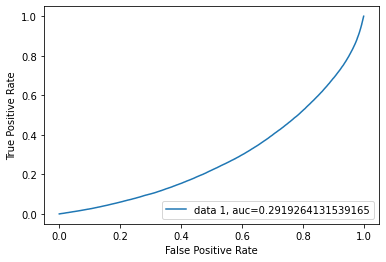

Precision: 0.586770304568528
Recall: 0.04367539229924551
F1 score: 0.08129938349615921


,Column,Amount
3,TaxiOut,3.001179
1,Distance,1.576902
133,AirportToState_NJ,0.980905
4,AirportFromLat,0.860528
2,TaxiIn,0.731974
...,...,...
81,AirportFromState_MT,-0.750863
92,AirportFromState_OR,-0.778666
99,AirportFromState_UT,-0.941482
102,AirportFromState_WA,-0.951189


In [33]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train, y_train, X_test, y_test)
importances

As we can see, LogisticRegression performs not so well in this dataset. I guess because the dataset doesn't have linear trending features to feed to the model.

In [34]:
del model1
del _

#### Decision Tree

Total time to train model: 62.80951166152954
Test score: 0.7994509110739202
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.89      0.88    553455
     class 1       0.24      0.23      0.24     84693

    accuracy                           0.80    638148
   macro avg       0.56      0.56      0.56    638148
weighted avg       0.80      0.80      0.80    638148



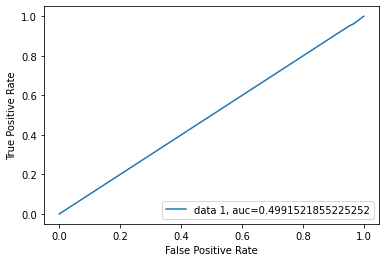

Precision: 0.23826051202670182
Recall: 0.23262843446329684
F1 score: 0.23541079195144096


In [35]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test)
importances

The recall is higher, we could predict 24% of late flight correctly

In [36]:
del model2
del _

#### Naive Bayes

Total time to train model: 12.996561527252197
Test score: 0.7291239649736425
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.79      0.83    553455
     class 1       0.20      0.35      0.26     84693

    accuracy                           0.73    638148
   macro avg       0.54      0.57      0.54    638148
weighted avg       0.80      0.73      0.76    638148



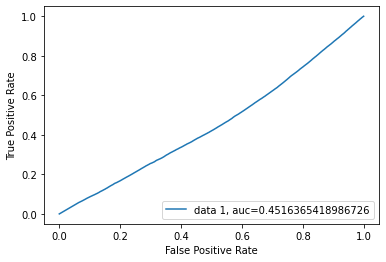

Precision: 0.20097001763668432
Recall: 0.3498163956879553
F1 score: 0.2552808330425267


In [37]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train, y_train, X_test, y_test)
importances

In [38]:
del model3
del _

#### Support Vector Machine

In [39]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 683.5149717330933
Test score: 0.8454284645519555
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.91    553993
     class 1       0.33      0.16      0.21     84928

    accuracy                           0.85    638921
   macro avg       0.60      0.55      0.56    638921
weighted avg       0.81      0.85      0.82    638921



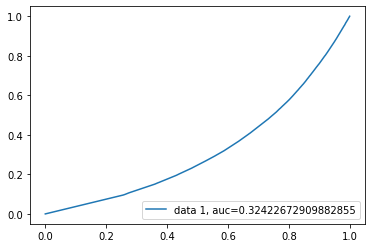

Precision: 0.3280368021882382
Recall: 0.15533157498116051
F1 score: 0.21083080955387037


In [35]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train, y_train, X_test, y_test)
importances

In [36]:
del model5
del _

## PCA

In [51]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

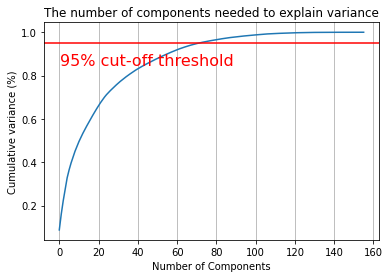

In [52]:
fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')
plt.show()

In [ ]:
pca = PCA(n_components=70).fit(X_train)

In [42]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [50]:
# import sys

# local_vars = list(locals().items())
# for var, obj in local_vars:
#     print(var, sys.getsizeof(obj))

#### Logistic Regression

Total time to train model: 6.655009031295776
Test score: 0.868735779160947
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    553455
     class 1       0.58      0.04      0.07     84693

    accuracy                           0.87    638148
   macro avg       0.73      0.52      0.50    638148
weighted avg       0.83      0.87      0.82    638148



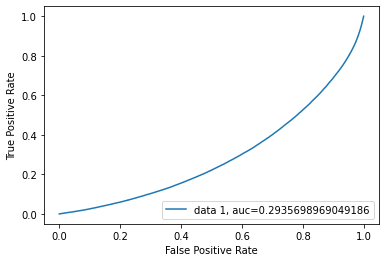

Precision: 0.5793256888584631
Recall: 0.039967884004581254
F1 score: 0.07477688433330389


,Column,Amount
60,60,1.183171
62,62,0.955352
61,61,0.951208
52,52,0.928607
64,64,0.831141
...,...,...
15,15,-0.503172
55,55,-0.563757
1,1,-0.892335
57,57,-0.991803


In [47]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_pca, y_train, X_test_pca, y_test)
importances

In [49]:
del model1
del _

#### Decision Tree

Total time to train model: 495.3743784427643
Test score: 0.7997439465453156
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.89      0.88    553455
     class 1       0.24      0.23      0.23     84693

    accuracy                           0.80    638148
   macro avg       0.56      0.56      0.56    638148
weighted avg       0.80      0.80      0.80    638148



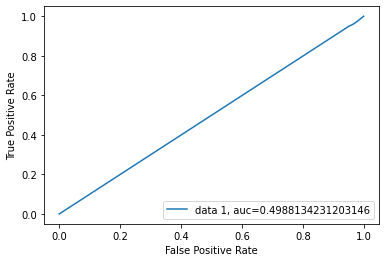

Precision: 0.23748964576328996
Recall: 0.23019612010437698
F1 score: 0.2337860119315286


AttributeError: 'DecisionTreeClassifier' object has no attribute 'coef_'

In [50]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

All of the scores decrease slightly when using PCA, around 0.00x

In [ ]:
del model2
del _

#### Naive Bayes

Total time to train model: 1.4255845546722412
Test score: 0.8085757535869422
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.90      0.89    553455
     class 1       0.26      0.24      0.25     84693

    accuracy                           0.81    638148
   macro avg       0.57      0.57      0.57    638148
weighted avg       0.80      0.81      0.81    638148



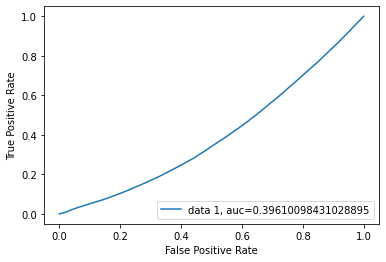

Precision: 0.26212125060320524
Recall: 0.24371553729351894
F1 score: 0.252583532694155


In [54]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_pca, y_train, X_test_pca, y_test)
importances

Naive Bayes significantly decreases the recall score of late flight and increase not-late flight's recall

In [42]:
del model3
del _

#### Support Vector Machine

In [ ]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 3134.651504278183
Test score: 0.8458570739076202
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.91    553455
     class 1       0.32      0.14      0.20     84693

    accuracy                           0.85    638148
   macro avg       0.60      0.55      0.56    638148
weighted avg       0.80      0.85      0.82    638148



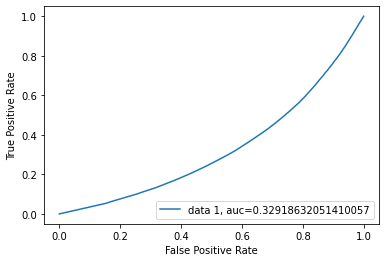

Precision: 0.31925974884335756
Recall: 0.14258557377823433
F1 score: 0.1971302176006791


In [56]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_pca, y_train, X_test_pca, y_test)
importances

In [57]:
del model5
del _

## SelectKBest

In [58]:
from sklearn.feature_selection import SelectKBest

selectKBest = SelectKBest(k=20)
selectKBest.fit(X_train, y_train)
X_train_kbest = selectKBest.transform(X_train)
X_test_kbest = selectKBest.transform(X_test)

print("New shape after transforming: ", X_train_kbest.shape)

New shape after transforming:  (1914443, 20)


In [72]:
selectKBest.pvalues_

array([1.37880286e-031, 2.43935406e-001, 0.00000000e+000, 0.00000000e+000,
       3.15145612e-219, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       5.98188184e-003, 1.04798422e-016, 5.08834875e-146, 1.18409373e-260,
       0.00000000e+000, 3.14977489e-024, 2.66513333e-006, 0.00000000e+000,
       1.29115494e-005, 8.72315607e-070, 1.05248998e-074, 3.03706073e-036,
       1.81841928e-009, 2.03683448e-090, 0.00000000e+000, 1.85021585e-027,
       9.38146688e-241, 4.55935852e-102, 4.00285628e-136, 7.95802793e-001,
       7.85444633e-017, 1.36302933e-036, 1.04391058e-001, 2.02385172e-001,
       6.50533945e-002, 9.15793706e-001, 0.00000000e+000, 1.07953257e-300,
       1.79170288e-047, 5.16315763e-005, 3.65619733e-005, 3.46134224e-002,
       1.78420999e-001, 1.38678402e-051, 4.35724519e-001, 1.25199518e-001,
       7.39513793e-004, 9.58761108e-004, 1.75467582e-001, 1.03764087e-002,
       2.68517467e-080, 1.76704209e-100, 1.10851909e-022, 2.04945380e-001,
       3.80433419e-005, 6

#### Logistic Regression

Total time to train model: 3.9925131797790527
Test score: 0.868408268928211
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93    553455
     class 1       0.57      0.04      0.07     84693

    accuracy                           0.87    638148
   macro avg       0.72      0.52      0.50    638148
weighted avg       0.83      0.87      0.81    638148



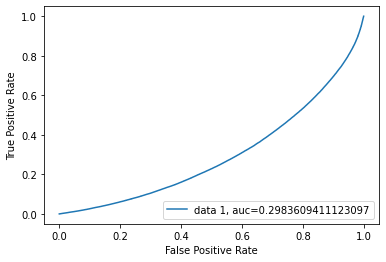

Precision: 0.5682509505703423
Recall: 0.035292172906851806
F1 score: 0.06645692750658677


,Amount
1,2.754987
0,0.696285
17,0.694247
15,0.648253
6,0.551213
18,0.491123
19,0.436448
5,0.325928
9,0.278699
16,0.245612


In [59]:
model1, _, importances = train_n_visualize_model(LogisticRegression, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [60]:
del model1
del _

#### Decision Tree

Total time to train model: 11.025588750839233
Test score: 0.8100471990823446
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.90      0.89    553455
     class 1       0.24      0.20      0.22     84693

    accuracy                           0.81    638148
   macro avg       0.56      0.55      0.56    638148
weighted avg       0.80      0.81      0.80    638148



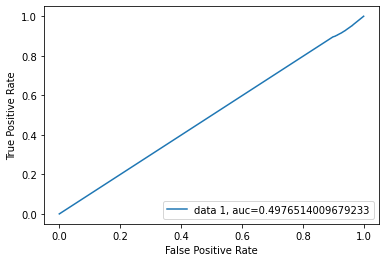

Precision: 0.24299525746210895
Recall: 0.20387753415276352
F1 score: 0.2217242796240177


In [61]:
model2, _, importances = train_n_visualize_model(DecisionTreeClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

All of the scores decrease slightly when using PCA, around 0.00x

In [62]:
del model2
del _

#### Naive Bayes

Total time to train model: 1.0513005256652832
Test score: 0.7837633276293273
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.89      0.86      0.87    553455
     class 1       0.24      0.30      0.27     84693

    accuracy                           0.78    638148
   macro avg       0.57      0.58      0.57    638148
weighted avg       0.80      0.78      0.79    638148



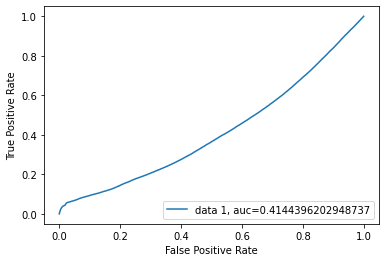

Precision: 0.24352780397667123
Recall: 0.2987732162044089
F1 score: 0.26833652352345455


In [63]:
model3, _, importances = train_n_visualize_model(GaussianNB, X_train_kbest, y_train, X_test_kbest, y_test)
importances

Naive Bayes significantly decreases the recall score of late flight and increase not-late flight's recall

In [64]:
del model3
del _

#### Support Vector Machine

In [65]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model4 = SVC(gamma="auto", max_iter=200, probability=True)
# model4.fit(X_train, y_train)

# y_pred = model4.predict(X_test)
# y_pred_prob = model4.predict_proba(X_test).max(axis=1)

### Random Forest

Total time to train model: 218.8849391937256
Test score: 0.841925384080182
Precision matrix:
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.91    553455
     class 1       0.30      0.15      0.20     84693

    accuracy                           0.84    638148
   macro avg       0.59      0.55      0.56    638148
weighted avg       0.80      0.84      0.82    638148



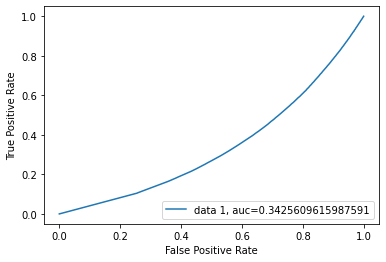

Precision: 0.3028508771929825
Recall: 0.1467535687719174
F1 score: 0.19770465987449595


In [66]:
model5, _, importances = train_n_visualize_model(RandomForestClassifier, X_train_kbest, y_train, X_test_kbest, y_test)
importances

In [67]:
del model5
del _

In [ ]:
selectKBest